In [19]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

In [23]:
dataset_name = "beans"
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    dataset_name, split=["train", "test", "validation"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [32]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

2024-06-14 11:58:17.349386: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-14 11:58:17.363453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


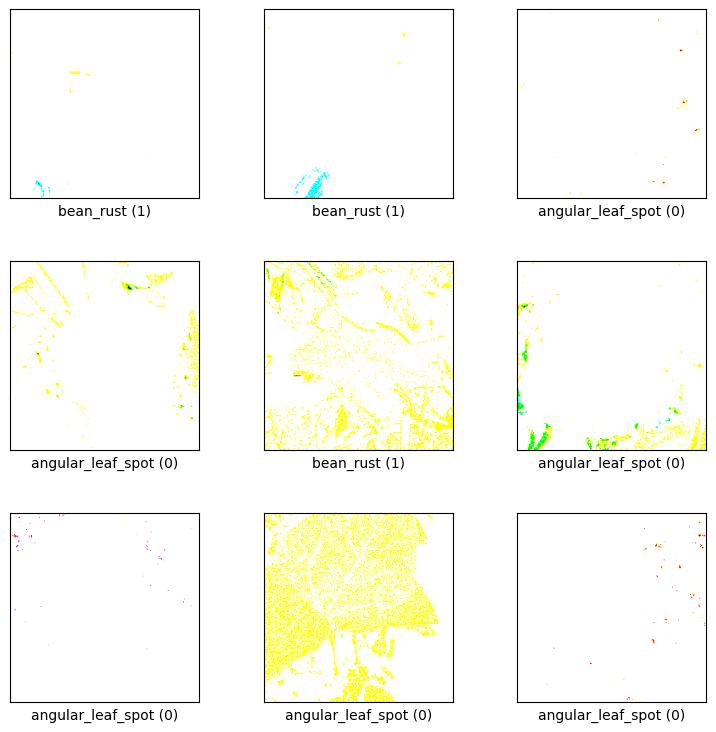

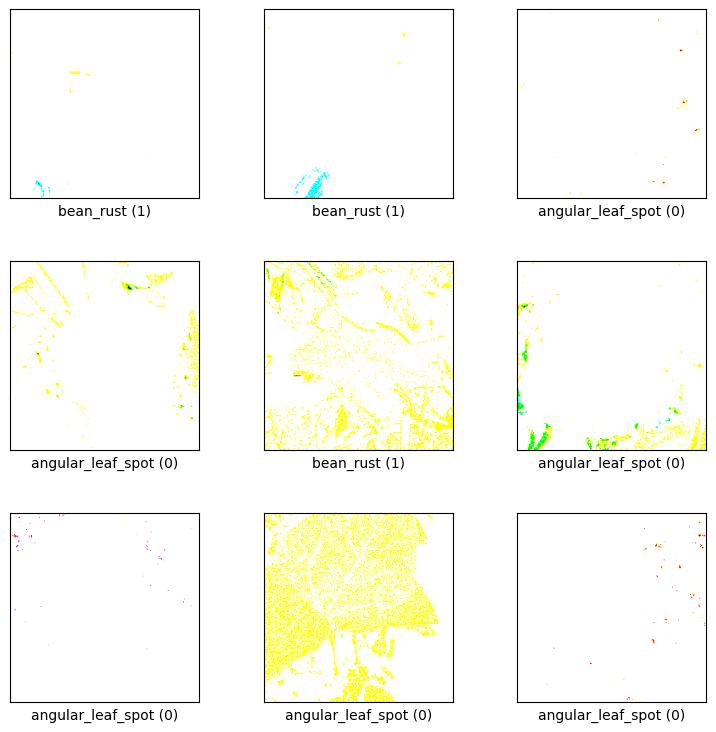

In [33]:
tfds.visualization.show_examples(ds=ds_train,  ds_info = ds_info )

2024-06-14 11:58:53.446778: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-14 11:58:53.458851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


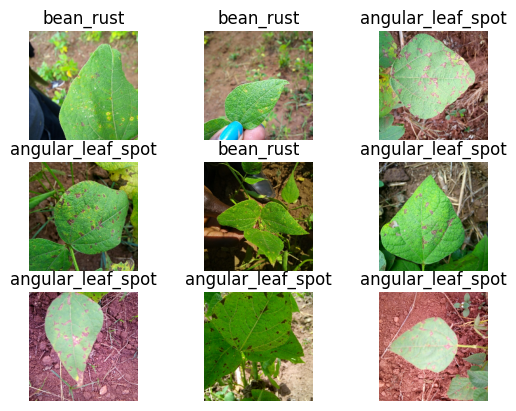

In [35]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(format_label(label))
    plt.axis("off")

In [36]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

2024-06-14 11:59:23.960055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-14 11:59:24.219746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


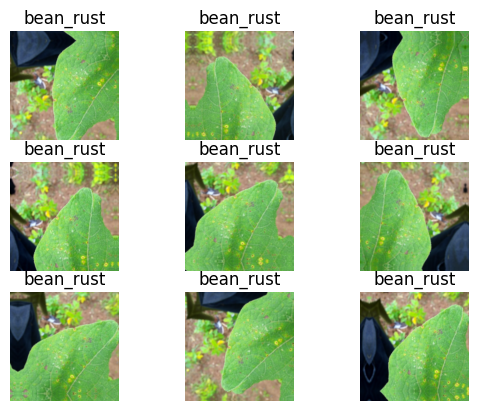

In [38]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title(format_label(label))
        plt.axis("off")

In [39]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [40]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.3735 - loss: 4.3117 - val_accuracy: 0.3359 - val_loss: 1.1009
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.3442 - loss: 2.3377 - val_accuracy: 0.3359 - val_loss: 1.2053
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.4433 - loss: 2.2776 - val_accuracy: 0.3359 - val_loss: 1.4367
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.4889 - loss: 2.1783 - val_accuracy: 0.3359 - val_loss: 1.5763
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.5070 - loss: 1.4357 - val_accuracy: 0.3359 - val_loss: 1.2662
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.5241 - loss: 1.8992 - val_accuracy: 0.3359 - val_loss: 1.2475
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.5934 - loss: 1.6580 - val_accuracy: 0.3359 - val_loss: 1.2657
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.5813 - loss: 1.4306 - val_accuracy: 0.3359 - val_loss

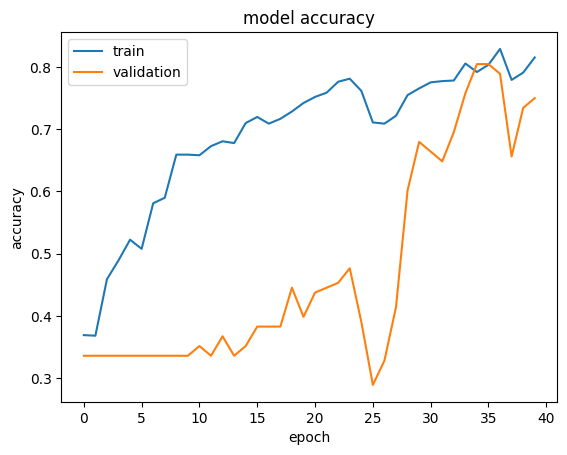

In [41]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [42]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 993ms/step - accuracy: 0.5853 - loss: 1.3523 - val_accuracy: 0.7656 - val_loss: 0.5957
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step - accuracy: 0.8188 - loss: 0.5915 - val_accuracy: 0.7891 - val_loss: 0.5039
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 891ms/step - accuracy: 0.8598 - loss: 0.5549 - val_accuracy: 0.8203 - val_loss: 0.4167
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - accuracy: 0.8747 - loss: 0.4271 - val_accuracy: 0.8281 - val_loss: 0.3768
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step - accuracy: 0.8518 - loss: 0.4373 - val_accuracy: 0.7891 - val_loss: 0.4540
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step - accuracy: 0.8585 - loss: 0.4194 - val_accuracy: 0.8750 - val_loss: 0.3471
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 897ms/step - accuracy: 0.8759 - loss: 0.4294 - val_accuracy: 0.8047 - val_loss: 0.4190
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step - accuracy: 0.8650 - loss: 0.4769 - val_accu

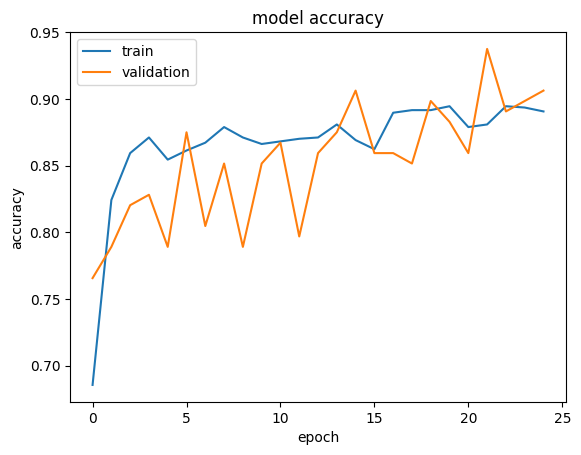

In [43]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)